# Modelos de Clasificación para Predicción de Fallas

Este notebook utiliza modelos de clasificación para predecir fallas en equipos industriales.

**Modelos utilizados:**
- Árbol de Decisión (Decision Tree)
- LightGBM

**Objetivo:** Predecir si un activo tendrá una falla en la próxima semana (7 días).

**Datos:** Tabla `faliure_probability_base` con granularidad diaria (`reading_date`) y variable objetivo `faliure`.

## 1. Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
from lightgbm import LGBMClassifier
import mysql.connector
from mysql.connector import Error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Carga de Datos desde MySQL

In [2]:
# Configuración de la base de datos
DB_CONFIG = {
    'host': '127.0.0.1',
    'database': 'palantir_maintenance',
    'user': 'root',
    'password': 'admin',
    'port': 3306
}

def cargar_datos():
    """Cargar datos de la tabla faliure_probability_base"""
    try:
        connection = mysql.connector.connect(**DB_CONFIG)
        if connection.is_connected():
            query = """
            SELECT * 
            FROM faliure_probability_base
            ORDER BY asset_id, reading_date
            """
            df = pd.read_sql(query, connection)
            connection.close()
            return df
    except Error as e:
        print(f"Error al conectar: {e}")
        return None

# Cargar datos
df = cargar_datos()
if df is not None:
    print(f"Datos cargados: {df.shape}")
    print(f"\nColumnas: {list(df.columns)}")
    print(f"\nPrimeras filas:")
    display(df.head())
else:
    print("No se pudieron cargar los datos")

Datos cargados: (256, 44)

Columnas: ['base_id', 'asset_id', 'reading_date', 'faliure', 'extraction_date', 'asset_age_days', 'asset_status', 'sensor_total_readings_30d', 'sensor_warning_count_30d', 'sensor_critical_count_30d', 'sensor_avg_normal_value', 'sensor_avg_warning_value', 'sensor_avg_critical_value', 'sensor_max_value', 'sensor_min_value', 'sensor_std_value', 'failure_count_365d', 'failure_critical_count', 'failure_high_count', 'failure_medium_count', 'failure_low_count', 'failure_avg_downtime', 'failure_total_downtime', 'failure_unresolved_count', 'days_since_last_failure', 'task_total_365d', 'task_completed_count', 'task_in_progress_count', 'task_pending_count', 'task_avg_estimated_hours', 'task_avg_actual_hours', 'task_total_hours', 'days_since_last_task', 'order_total_365d', 'order_preventive_count', 'order_corrective_count', 'order_emergency_count', 'order_completed_count', 'order_avg_estimated_cost', 'order_avg_actual_cost', 'order_total_actual_cost', 'days_since_last_or

,base_id,asset_id,reading_date,faliure,extraction_date,asset_age_days,asset_status,sensor_total_readings_30d,sensor_warning_count_30d,sensor_critical_count_30d,...,order_preventive_count,order_corrective_count,order_emergency_count,order_completed_count,order_avg_estimated_cost,order_avg_actual_cost,order_total_actual_cost,days_since_last_order,created_at,updated_at
0,2,1,2022-10-01,1,2026-01-25 20:36:35,990,operational,48,5,0,...,69,37,3,37,4580.13,4811.36,178020.43,6,2026-01-25 20:36:35,2026-01-25 20:36:35
1,10,1,2022-10-02,1,2026-01-25 20:36:35,991,operational,96,8,0,...,69,37,3,37,4580.13,4811.36,178020.43,7,2026-01-25 20:36:35,2026-01-25 20:36:35
2,18,1,2022-10-03,1,2026-01-25 20:36:35,992,operational,144,12,0,...,69,37,3,37,4580.13,4811.36,178020.43,8,2026-01-25 20:36:35,2026-01-25 20:36:35
3,26,1,2022-10-04,1,2026-01-25 20:36:35,993,operational,192,16,0,...,69,37,3,37,4580.13,4811.36,178020.43,9,2026-01-25 20:36:35,2026-01-25 20:36:35
4,34,1,2022-10-05,1,2026-01-25 20:36:35,994,operational,240,21,0,...,69,37,3,37,4580.13,4811.36,178020.43,10,2026-01-25 20:36:35,2026-01-25 20:36:35


## 3. Análisis de la Variable Objetivo

Distribución de la variable 'faliure' (falla en próximos 7 días):
faliure
1    152
0    104
Name: count, dtype: int64

Tasa de fallas: 59.38%


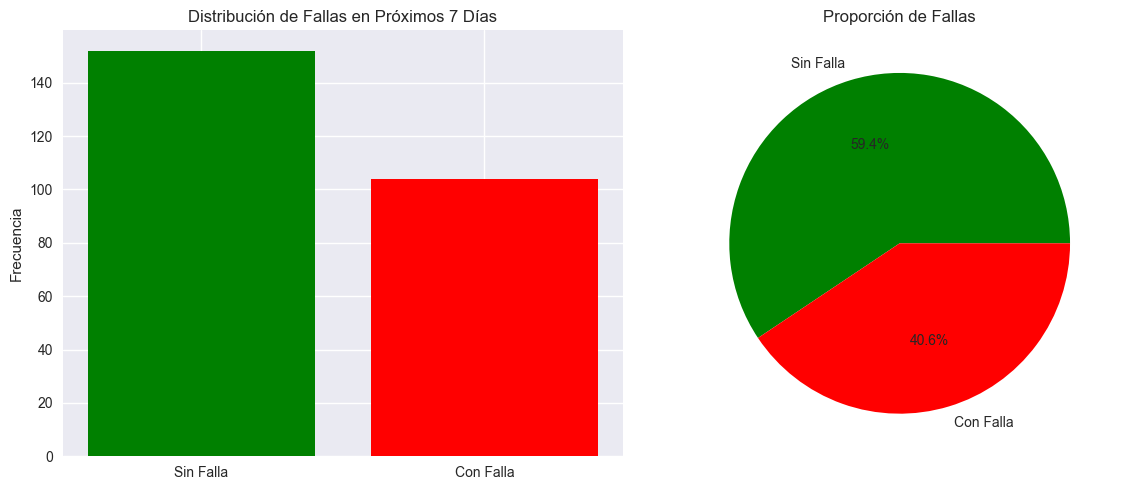

In [3]:
if df is not None and 'faliure' in df.columns:
    # Distribución de la variable objetivo
    print("Distribución de la variable 'faliure' (falla en próximos 7 días):")
    print(df['faliure'].value_counts())
    print(f"\nTasa de fallas: {df['faliure'].mean()*100:.2f}%")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Gráfico de barras
    faliure_counts = df['faliure'].value_counts()
    axes[0].bar(['Sin Falla', 'Con Falla'], faliure_counts.values, color=['green', 'red'])
    axes[0].set_title('Distribución de Fallas en Próximos 7 Días')
    axes[0].set_ylabel('Frecuencia')
    
    # Gráfico de pie
    axes[1].pie(faliure_counts.values, labels=['Sin Falla', 'Con Falla'], 
                autopct='%1.1f%%', colors=['green', 'red'])
    axes[1].set_title('Proporción de Fallas')
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos o columna 'faliure' no encontrada")

## 4. Preparación de Datos

In [4]:
if df is not None and 'faliure' in df.columns:
    # Columnas a excluir
    exclude_cols = ['base_id', 'asset_id', 'reading_date', 'faliure', 
                    'asset_status', 'created_at', 'updated_at']
    
    # Seleccionar características numéricas
    feature_columns = [col for col in df.columns if col not in exclude_cols]
    
    # Preparar datos
    X = df[feature_columns].select_dtypes(include=[np.number]).fillna(0)
    y = df['faliure'].astype(int)
    
    print(f"Características seleccionadas: {len(X.columns)}")
    print(f"\nColumnas: {list(X.columns)}")
    print(f"\nForma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
    print(f"\nDistribución de clases:")
    print(y.value_counts())
else:
    print("No hay datos disponibles")

Características seleccionadas: 36

Columnas: ['asset_age_days', 'sensor_total_readings_30d', 'sensor_warning_count_30d', 'sensor_critical_count_30d', 'sensor_avg_normal_value', 'sensor_avg_warning_value', 'sensor_avg_critical_value', 'sensor_max_value', 'sensor_min_value', 'sensor_std_value', 'failure_count_365d', 'failure_critical_count', 'failure_high_count', 'failure_medium_count', 'failure_low_count', 'failure_avg_downtime', 'failure_total_downtime', 'failure_unresolved_count', 'days_since_last_failure', 'task_total_365d', 'task_completed_count', 'task_in_progress_count', 'task_pending_count', 'task_avg_estimated_hours', 'task_avg_actual_hours', 'task_total_hours', 'days_since_last_task', 'order_total_365d', 'order_preventive_count', 'order_corrective_count', 'order_emergency_count', 'order_completed_count', 'order_avg_estimated_cost', 'order_avg_actual_cost', 'order_total_actual_cost', 'days_since_last_order']

Forma de X: (256, 36)
Forma de y: (256,)

Distribución de clases:
fali

## 5. División de Datos en Train y Test

In [5]:
if 'X' in locals() and 'y' in locals() and len(np.unique(y)) > 1:
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Datos de entrenamiento: {X_train.shape}")
    print(f"Datos de prueba: {X_test.shape}")
    print(f"\nDistribución en entrenamiento:")
    print(y_train.value_counts())
    print(f"\nDistribución en prueba:")
    print(y_test.value_counts())
    
    # Estandarizar características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convertir a DataFrame para LightGBM
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    print("\nDatos estandarizados correctamente")
else:
    print("No hay datos preparados o solo hay una clase")

Datos de entrenamiento: (204, 36)
Datos de prueba: (52, 36)

Distribución en entrenamiento:
faliure
1    121
0     83
Name: count, dtype: int64

Distribución en prueba:
faliure
1    31
0    21
Name: count, dtype: int64

Datos estandarizados correctamente


## 6. Modelo 1: Árbol de Decisión

ÁRBOL DE DECISIÓN - RESULTADOS

Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   1.0000

Reporte de Clasificación:
              precision    recall  f1-score   support

   Sin Falla       1.00      1.00      1.00        21
   Con Falla       1.00      1.00      1.00        31

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



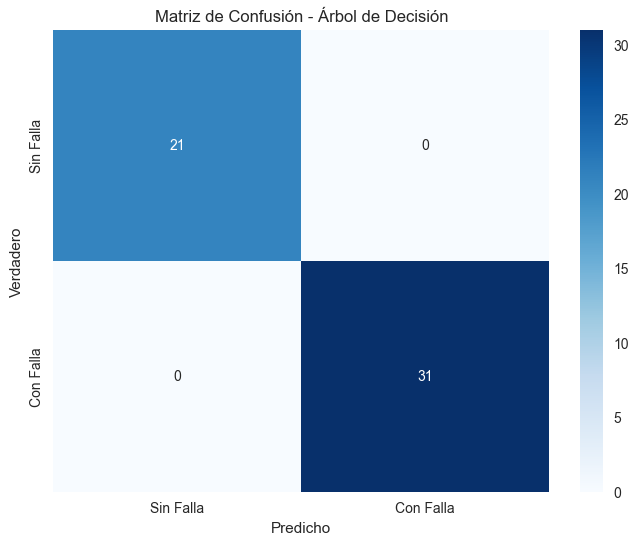

In [6]:
if 'X_train' in locals():
    # Crear y entrenar árbol de decisión
    dt_model = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',  # Manejo de datos desbalanceados
        random_state=42
    )
    
    dt_model.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_pred_dt = dt_model.predict(X_test_scaled)
    y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
    
    # Métricas
    print("="*60)
    print("ÁRBOL DE DECISIÓN - RESULTADOS")
    print("="*60)
    print(f"\nAccuracy:  {accuracy_score(y_test, y_pred_dt):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_dt, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred_dt, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_test, y_pred_dt, zero_division=0):.4f}")
    
    if len(np.unique(y_test)) > 1:
        print(f"AUC-ROC:   {roc_auc_score(y_test, y_pred_proba_dt):.4f}")
    
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred_dt, 
                                target_names=['Sin Falla', 'Con Falla'],
                                zero_division=0))
    
    # Matriz de confusión
    cm_dt = confusion_matrix(y_test, y_pred_dt)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Sin Falla', 'Con Falla'],
                yticklabels=['Sin Falla', 'Con Falla'])
    plt.title('Matriz de Confusión - Árbol de Decisión')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()
else:
    print("No hay datos de entrenamiento")

## 7. Visualización del Árbol de Decisión

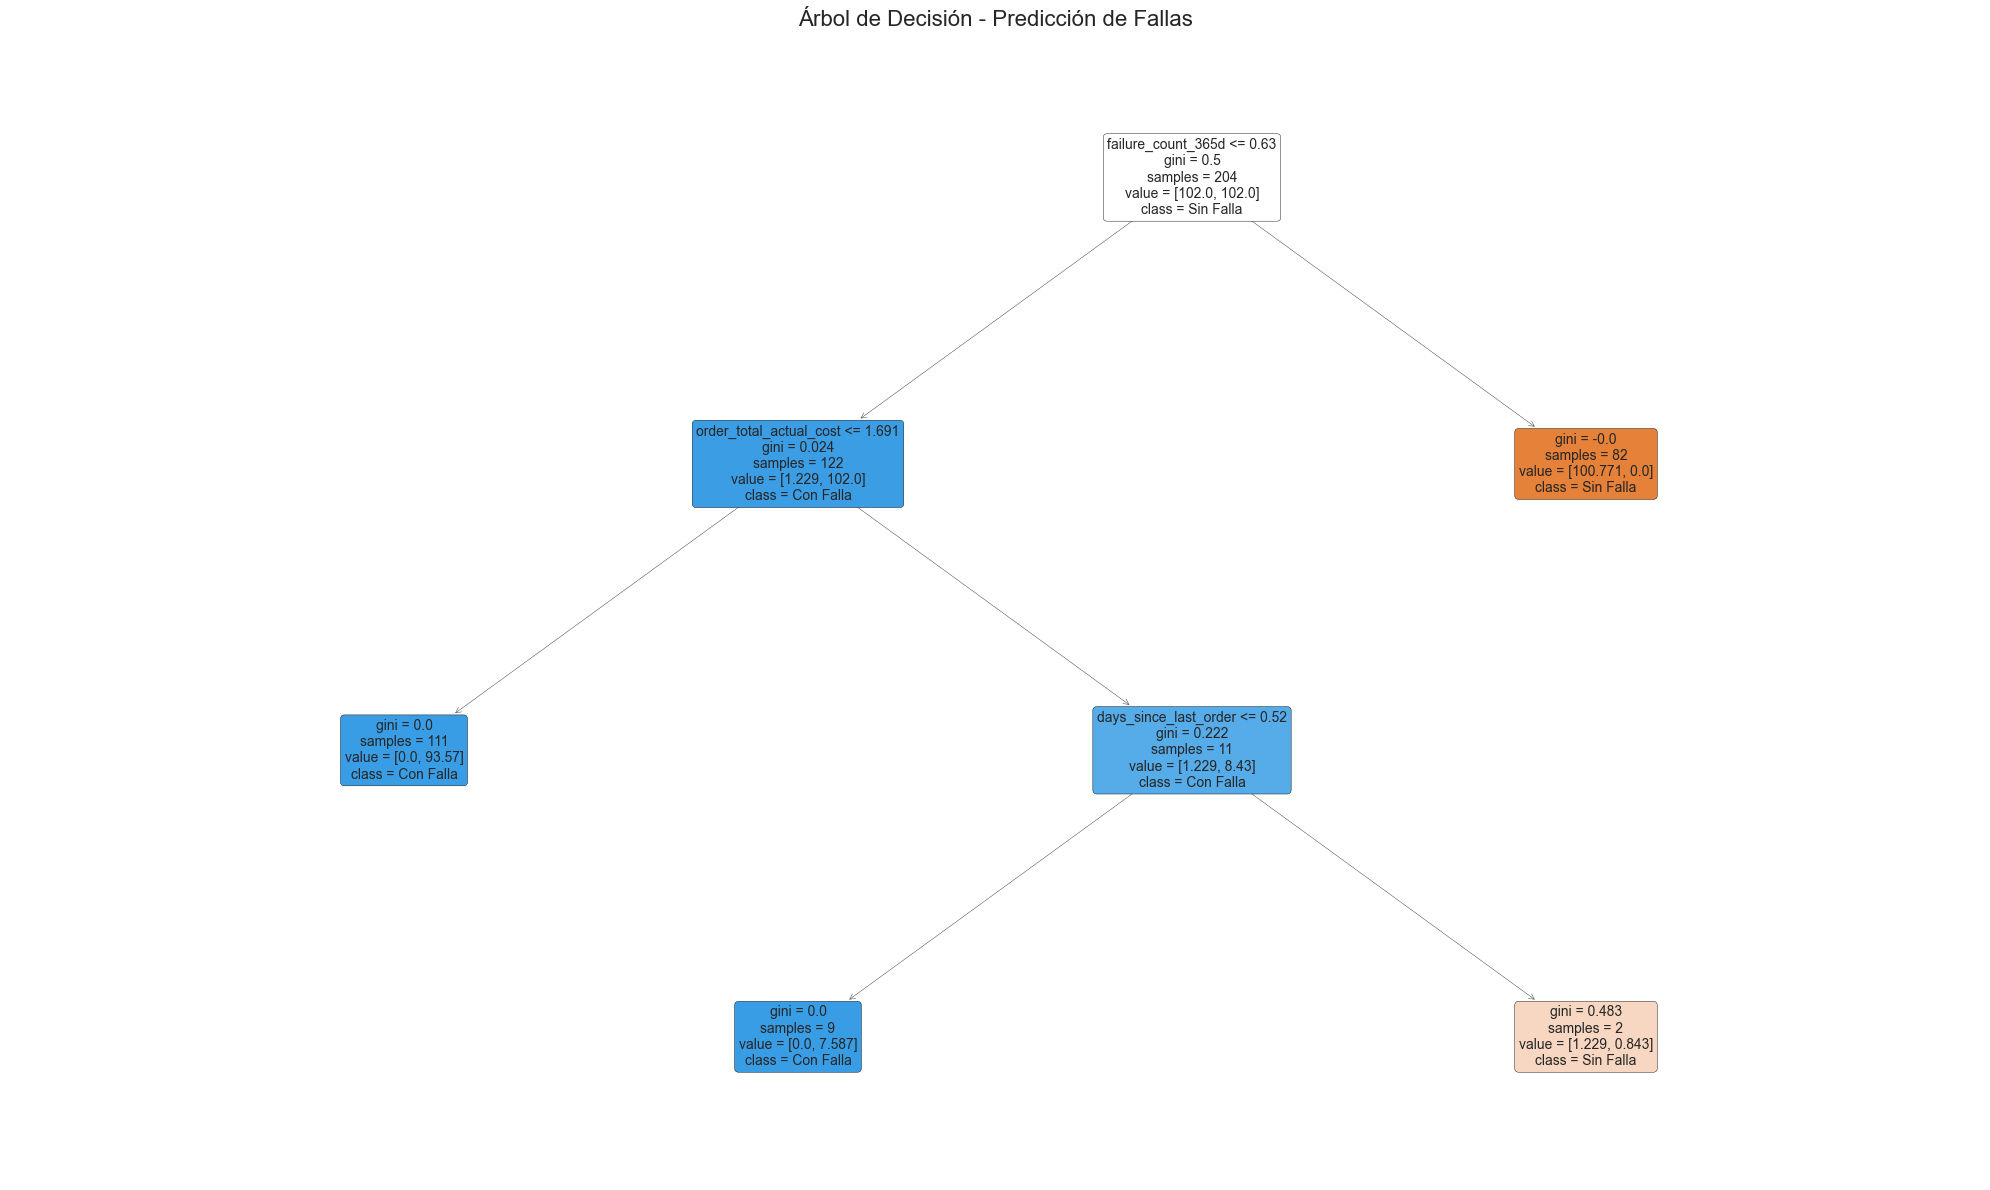

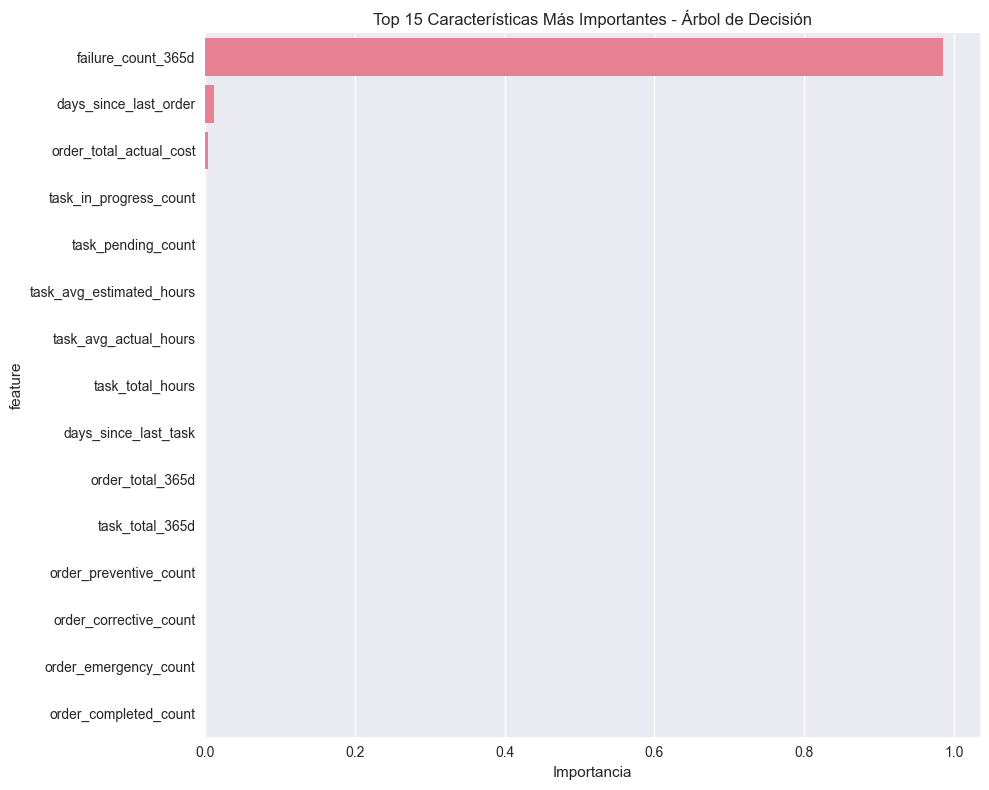


Top 10 características más importantes:
                     feature  importance
10        failure_count_365d    0.985856
35     days_since_last_order    0.011338
34   order_total_actual_cost    0.002807
21    task_in_progress_count    0.000000
22        task_pending_count    0.000000
23  task_avg_estimated_hours    0.000000
24     task_avg_actual_hours    0.000000
25          task_total_hours    0.000000
26      days_since_last_task    0.000000
27          order_total_365d    0.000000


In [7]:
if 'dt_model' in locals() and 'X_train' in locals():
    # Visualizar árbol (limitado a profundidad 3 para visualización)
    plt.figure(figsize=(20, 12))
    plot_tree(dt_model, 
              feature_names=X_train.columns,
              class_names=['Sin Falla', 'Con Falla'],
              filled=True,
              rounded=True,
              fontsize=10,
              max_depth=3)
    plt.title('Árbol de Decisión - Predicción de Fallas', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Importancia de características
    dt_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': dt_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=dt_importance.head(15), x='importance', y='feature')
    plt.title('Top 15 Características Más Importantes - Árbol de Decisión')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 características más importantes:")
    print(dt_importance.head(10))
else:
    print("No hay modelo entrenado")

## 8. Modelo 2: LightGBM

In [ ]:
if 'X_train' in locals():
    # Calcular peso para datos desbalanceados
    n_neg = np.sum(y_train == 0)
    n_pos = np.sum(y_train == 1)
    scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1
    
    # Crear y entrenar LightGBM
    lgbm_model = LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        boosting_type='gbdt',
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=100,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        verbose=-1
    )
    
    # Entrenar con early stopping
    lgbm_model.fit(
        X_train_scaled_df, y_train,
        eval_set=[(X_test_scaled_df, y_test)],
        eval_names=['valid'],
        #callbacks=[
        #    lgbm_model.early_stopping(stopping_rounds=20, verbose=False)
        #]
    )
    
    # Predicciones
    y_pred_lgbm = lgbm_model.predict(X_test_scaled_df)
    y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_scaled_df)[:, 1]
    
    # Métricas
    print("="*60)
    print("LIGHTGBM - RESULTADOS")
    print("="*60)
    print(f"\nAccuracy:  {accuracy_score(y_test, y_pred_lgbm):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_lgbm, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred_lgbm, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_test, y_pred_lgbm, zero_division=0):.4f}")
    
    if len(np.unique(y_test)) > 1:
        print(f"AUC-ROC:   {roc_auc_score(y_test, y_pred_proba_lgbm):.4f}")
    
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred_lgbm, 
                                target_names=['Sin Falla', 'Con Falla'],
                                zero_division=0))
    
    # Matriz de confusión
    cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=['Sin Falla', 'Con Falla'],
                yticklabels=['Sin Falla', 'Con Falla'])
    plt.title('Matriz de Confusión - LightGBM')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()
else:
    print("No hay datos de entrenamiento")

AttributeError: 'LGBMClassifier' object has no attribute 'early_stopping'

## 9. Importancia de Características - LightGBM

In [ ]:
if 'lgbm_model' in locals():
    # Importancia de características
    lgbm_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': lgbm_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=lgbm_importance.head(15), x='importance', y='feature', palette='viridis')
    plt.title('Top 15 Características Más Importantes - LightGBM')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 características más importantes:")
    print(lgbm_importance.head(10))
else:
    print("No hay modelo LightGBM entrenado")

## 10. Comparación de Modelos

In [ ]:
if 'y_pred_dt' in locals() and 'y_pred_lgbm' in locals():
    # Comparar modelos
    modelos = {
        'Árbol de Decisión': (y_pred_dt, y_pred_proba_dt),
        'LightGBM': (y_pred_lgbm, y_pred_proba_lgbm)
    }
    
    resultados = []
    for nombre, (predicciones, probabilidades) in modelos.items():
        result = {
            'Modelo': nombre,
            'Accuracy': accuracy_score(y_test, predicciones),
            'Precision': precision_score(y_test, predicciones, zero_division=0),
            'Recall': recall_score(y_test, predicciones, zero_division=0),
            'F1-Score': f1_score(y_test, predicciones, zero_division=0)
        }
        if len(np.unique(y_test)) > 1:
            result['AUC-ROC'] = roc_auc_score(y_test, probabilidades)
        resultados.append(result)
    
    df_resultados = pd.DataFrame(resultados)
    print("="*60)
    print("COMPARACIÓN DE MODELOS")
    print("="*60)
    print(df_resultados.round(4).to_string(index=False))
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 6))
    df_resultados.set_index('Modelo').plot(kind='bar', ax=ax)
    plt.title('Comparación de Métricas entre Modelos')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(title='Métricas', loc='lower right')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()
    
    # Curvas ROC
    if len(np.unique(y_test)) > 1:
        plt.figure(figsize=(8, 6))
        
        # Árbol de Decisión
        fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
        auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
        plt.plot(fpr_dt, tpr_dt, label=f'Árbol de Decisión (AUC = {auc_dt:.3f})')
        
        # LightGBM
        fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
        auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
        plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curvas ROC - Comparación de Modelos')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No hay modelos entrenados para comparar")

## 11. Selección del Mejor Modelo

In [ ]:
if 'df_resultados' in locals():
    # Seleccionar mejor modelo basado en F1-Score
    best_idx = df_resultados['F1-Score'].idxmax()
    best_model_name = df_resultados.loc[best_idx, 'Modelo']
    best_f1 = df_resultados.loc[best_idx, 'F1-Score']
    
    print(f"\n{'='*60}")
    print("MEJOR MODELO SELECCIONADO")
    print(f"{'='*60}")
    print(f"\nModelo: {best_model_name}")
    print(f"F1-Score: {best_f1:.4f}")
    
    # Guardar modelos
    import joblib
    
    joblib.dump(dt_model, 'decision_tree_model.pkl')
    joblib.dump(lgbm_model, 'lightgbm_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    
    print("\nModelos guardados:")
    print("  - decision_tree_model.pkl")
    print("  - lightgbm_model.pkl")
    print("  - scaler.pkl")
else:
    print("No hay resultados disponibles")

## Resumen

En este notebook hemos:

1. ✅ Cargado datos de la tabla `faliure_probability_base` (granularidad diaria)
2. ✅ Analizado la variable objetivo `faliure` (falla en próximos 7 días)
3. ✅ Entrenado modelo de **Árbol de Decisión**
4. ✅ Entrenado modelo **LightGBM**
5. ✅ Comparado métricas de ambos modelos
6. ✅ Visualizado importancia de características
7. ✅ Guardado modelos para uso futuro

**Próximos pasos:** Usar el mejor modelo para predicciones en producción.